In [ ]:
%pip install pandas
%pip install numpy
%pip install regex
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import regex


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict

import time
import datetime

import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import pickle
import matplotlib.pyplot as plt

In [11]:
models = {
    "OLS": LinearRegression(),
    "Lasso": Lasso(max_iter=1_000_000),
    "Ridge": Ridge(max_iter=1_000_000),
    "Elastic Net": ElasticNet(max_iter=1_000_000),
    "Regression Tree": DecisionTreeRegressor(),
    "Random Forest Reg": RandomForestRegressor()
}
cv = cv = KFold(n_splits=10, random_state=1, shuffle=True)

def data_loader(filename, ma=None, minmax=False):
    #print(filename)
    df = pd.read_csv(filename,parse_dates=["date"])
    date = df["date"].dt.dayofyear
    df["doy"] = date
    df = df.set_index("date")
    if minmax:
        #print(X)
        scaler = MinMaxScaler()
        df.iloc[:,1:-1] = pd.DataFrame(scaler.fit_transform(df.iloc[:,1:-1]), index=df.index, columns=df.columns[1:-1])
    train = df[df.iloc[:,0].isna() == False]
    pred = df[df.iloc[:,0].isna()]

    X_pred = pred.iloc[:,1:].dropna(axis=1)
    train.dropna(axis=1)

    if ma:
        train.iloc[:,:-1] = train.iloc[:, :-1].rolling(ma).mean()
        train = train.dropna()
        X_pred.iloc[:, :-1] = X_pred.iloc[:, :-1].rolling(ma).mean()
        X_pred = X_pred.dropna()

        
    y_train = train.iloc[:,0]
    X_train = train.iloc[:,1:]

    return X_train, y_train, X_pred

In [14]:
for gas in ["NO2", "SO2", "CO", "PM25"]:
    #if gas != "SO2":
    score_cluster = pd.read_csv(f"../../data/API Recreate/model_score/cluster_{gas}.csv", index_col = 0)
    score_distance = pd.read_csv(f"../../data/API Recreate/model_score/distance_{gas}.csv", index_col = 0)
    model_selection_cluster = pd.DataFrame({"model":score_cluster.loc[[bool(regex.match(".*_R2", x)) for x in score_cluster.index]].idxmax(axis=0), "r2":score_cluster.loc[[bool(regex.match(".*_R2", x)) for x in score_cluster.index]].max(axis=0)})
    model_selection_distance = pd.DataFrame({"model":score_distance.loc[[bool(regex.match(".*_R2", x)) for x in score_distance.index]].idxmax(axis=0), "r2":score_distance.loc[[bool(regex.match(".*_R2", x)) for x in score_distance.index]].max(axis=0)})

    model_selection_cluster["filling"] = "cluster"
    model_selection_cluster = model_selection_cluster.reset_index(names="city")
    model_selection_distance["filling"] = "distance"
    model_selection_distance = model_selection_distance.reset_index(names="city")
    temp = pd.concat([model_selection_distance, model_selection_cluster]).reset_index(drop=True)
    #else:
    #    score =  pd.read_csv(f"../../data/API Recreate/model_score/cluster_SO2.csv", index_col = 0)
    #    temp = pd.DataFrame({"model":score.loc[[bool(regex.match(".*_R2", x)) for x in score.index]].idxmax(axis=0), "r2":score.loc[[bool(regex.match(".*_R2", x)) for x in score.index]].max(axis=0)}).reset_index(names="city")
    #    temp["filling"] = "cluster"
        
    temp = temp.loc[temp.groupby("city")["r2"].idxmax()]
    #display(temp)
    temp = temp[temp["r2"]>0.4].reset_index(drop=True)

    temp["file_dir"] = temp["filling"].apply(lambda x: {"distance":"../../data/Combined_data_for_recreate/distance/","cluster":"../../data/Combined_data_for_recreate/cluster/"}[x])
    temp["file_dir"] = temp["file_dir"]+temp["city"]+".csv"

    results = {}
    for i, row in temp[temp["r2"]>0.4].iterrows():

        if "ma7" in row["model"]:
            ma = 7
        else:
            ma = None
        model = models[row["model"].split("_")[0]]
        X_train, y_train, X_pred = data_loader(row["file_dir"], ma, True)

        model.fit(X_train, y_train)
        try: 
            y_pred = model.predict(X_pred)
        except:
            display(row)
            display(X_pred)
            display(X_pred[X_pred.isna().any(axis=1)])

        results[row["city"]] = [pd.Series(y_pred, X_pred.iloc[-len(y_pred):].index, name=f"predict_{gas}"), y_train]

    
    with open(f"../../data/API Recreate/pred/dicts_for_plot/{gas}.pkl", "wb") as f:
        pickle.dump(results, f)

    results = {key:pd.DataFrame(pd.concat(x), columns=[key]) for key, x in results.items()}
    out_csv = pd.DataFrame()
    for key, val in results.items():
        out_csv = out_csv.join(val, how="outer")
    out_csv.to_csv(f"../../data/API Recreate/pred/csv/{gas}_pred.csv")

In [ ]:
results = {}
for i, row in temp[temp["r2"]>0.4].iterrows():

    if "ma7" in row["model"]:
        ma = 7
    else:
        ma = None
    model = models[row["model"].split("_")[0]]
    X_train, y_train, X_pred = data_loader(row["file_dir"], ma, True)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_pred)
    
    results[row["city"]] = [pd.Series(y_pred, X_pred.index, name="predict_PM25"), y_train]
    

<AxesSubplot:xlabel='date'>

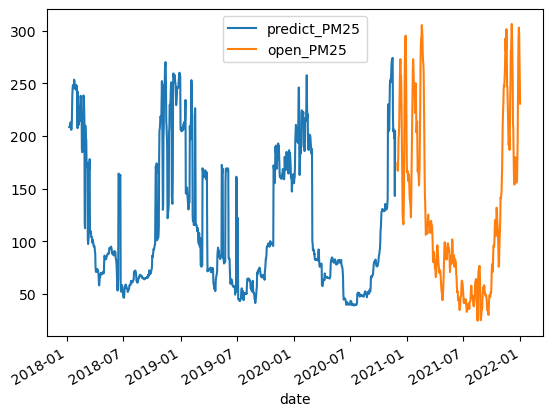

In [ ]:
pd.DataFrame(results["Agra_PM25"]).T.plot()